# 2. EDA

Goals:

- Select the variables for predictions.
- Discover other interesting trends.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
from scipy import stats
import statsmodels.api as sm
import plotly.graph_objects as go

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# !pip install plotly

sns.set()

pd.set_option('display.max_columns', 80)

In [2]:
%%time
training = pd.read_excel("../data/training_cleaned.xlsx")
test = pd.read_excel("../data/test_cleaned.xlsx")

Wall time: 29.9 s


In [3]:
def default_rate(lc_df):
    return lc_df["Loan Status"].mean()

## 2.1 Variable Selection

The purpose of this section is to select variables that will be used for predictive modeling. Recall we divided original variables into 4 baskets: Loan Conditions, Borrower Financial Strength, Credit Situation, and Payment History on Loans. Through both empirical reasoning and statistical testing, we identify 4-5 most significant variables for each category. Then we further shrink that list to less than 10 variables using correlation analysis and dimension reduction techniques.

Parrallely, we'll also perform some automated, model-based feature selection. These techniques typically utilize classifiers with L1 penalties which, when properly adjusted, will render the coefficients on some features 0. The downside of this method is its lack in interpretability: we almost never know why the variables are discarded. We simply include the results here as reference.

__Framework for basket-wise EDA__

1. First, within each basket, we identify a couple of variables that seem too essential to exclude. For example, for loan conditions they would be `Loan Size` and `Interest Rate`. 

1. We then incrementally test the inclusion of other variables. 

    1. For each variable, we first visually check whether by it by itself has any impact on default. We discard the variable if no correlation can be seen. Although regressors that aren't significant can become significant with the inclusion of more variables, <span style=color:red> that correlation tends to result from statistical procedure, not from actual correlation.</span> (An OLS example is that as we throw in more independent regressors, the RSS will decrease, reducing the $\hat{\sigma}$ and boosting the t-stat for existing variables. The independence assumption guarantees the projection onto existing columns spaces won't change by much.) 
    1. We then check how it's correlated against existing variables through plotting. If only weak correlation is present, then the variable probably exerts independent influence on default probability, and including the variable would incorpoate meaningful information.
    1. If correlations with existing variables are visually identifiable, then we perform an hypothesis testing against the null that the extra variable has no impact. We do thi through an ANOVA between two logistic regression models, one with just existing features and another with the addition of the interested variable. The test statistic is twice the difference between negative log-likelihood of two models. Statistial theory shows that this test statistic should follow a chi-square distribution with dof equaling the difference in number of paramters being estimated. (see U-Washington biostat class note below)
    
Through this framework, we can make ensure the included variables have an __explainable causality__ on impact. While causality isn't required for prediction in general, it's very important in assessing credit risk.

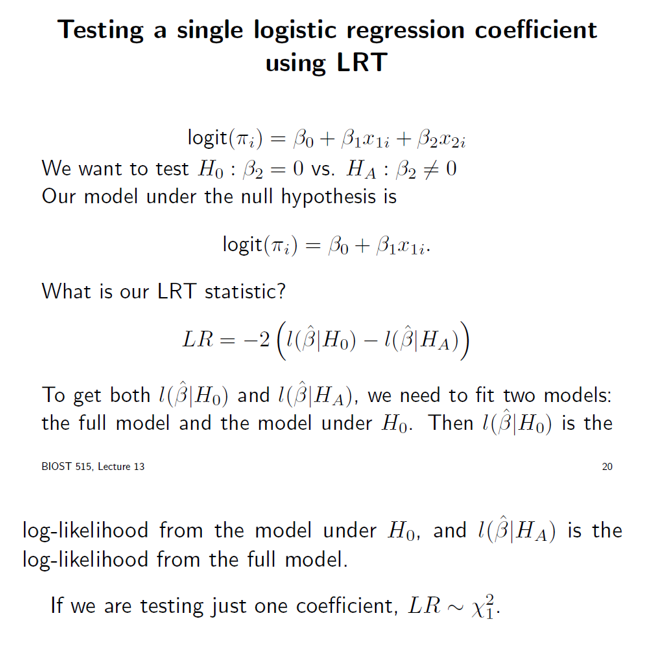

### 2.1.1 A One-line Predictor with 100% Accuracy? Features that shouldn't appear in prediction

#### Payment Data on Concluded Loans: Spurious Correlation

We can build a 100% accurate default predictor by testing whether the `Total Recieved Principle` is less than `Amound Funded`. The logic is simple: any concluded loan is defaulted on when and only when the principle is not fully paid. Both our training and test sets contain only concluded loans.

This is apparently too good to be true. In actual predictive settings, we won't have the luxury of owning such conclusive payment data. In real-world scenarios: we're either pricing a new loan, or monitoring an ongoing loan. In the first case, no payment data are available; in the second case, payment information in the training set captures spurious correlations that won't exist in the test set. Our training data is strictly conditioned on the fact that loans have already concluded; they don't say much about the feature dynamics given the loan is still ongoing. Just like a time series can be conditionally heteroscedastic but unconditionally homoscedastic, properties that exist under one condition will likely fail in general!

(Example on time series: let $\epsilon_i = f(x_i)\eta_i$, where $x_i$ and $\eta_i$ are independent, and both stationary and zero-mean. $Var(\epsilon_i|x_i) = f(x_i)^2Var(\eta_i)$ depends on $x_i$, but $Var(\epsilon_i) = Var(f(x_i))Var(\eta_i)$ which is constant.)

(We can also look at this from a modeling perspective. A 100% accurate predictor means that the model has captured the whole truth, and incorporating any other feature into the model would be overfitting. This would render the rest of the project meaningless. <span style=color:red> As such, we have to discard the any data related to loan payment.</span> )

_A Sidenote on Application Scenario_ 

Due to inherent deficiency in the dataset, we __don't__ recommend using this classifer to monitor any ongoing loans. A possible remedy would be expanding the dataset to include each feature's evolution through time, but doing so would make the dataframe 3D, and hence requires more advanced modeling techniques. 



In [4]:
# A 100% accurate classifier?
prediction = (test["Total Received Principle"] < test["Funded Amount"]).astype(int)
(prediction != test["Loan Status"]).sum()
# % of loans defaulted
training["Term"].value_counts().to_frame()/training.shape[0]

0

Term
 36 months  0.731453
 60 months  0.268547

#### Last Credit Pulled Date: Reverse Causality that won't Manifest Until Default

Below is a histogram of number of days that transpired between issuance and __LAST__ credit check (by Lending Club). Observe that at around day 1080, a large batch of loans go through their last credit check. This timing coincides with the actual lifespan of a majority of loans. Further notice the similarity in shape of both distributions prior to day 1080 -- almost as many loans terminate as have their last credit record pulled. If Lending Club performs regular credit check on on-going loans, this is the exact sort of behavior we'd see from the graph. 

Lending Club claims that they can make soft inquiries on applicant's credit scores (https://help.lendingclub.com/hc/en-us/articles/214869618-Will-checking-my-rate-affect-my-credit-score-). If they are not limited in the number of credit check they can perform, it makes perfect business sense to regularly soft-pull credit records for on-going loans. Therefore, the number of days that transpired between `Issued Date` and `Last Credit Pulled Date` can be intepreted as length of the period where the applicant's credit scoring is actively monitored. 

From the histogram we can see almost no defaulted loans have a monitoring period shorter than 36 months. A likely cause is that for defaulted borrowers, Lending Club would continue tracking their credit situation to assess the likelihood of recovery. In other words, it is because the loans have been defaulted on that their monitoring period is long, not the other way around.

Such reverse causality won't manifest itself for ongoing loans, because their credit monitoring period will almost certainly equal their current lifespan. Any information captured by `Last Credit Pulled Date` will likely be already incorporated in how long the loan has lasted. <span style=color:red> So even if we have time series data on each loan, `Last Credit Pulled Date` shouldn't be included as a predictive variable. </span>

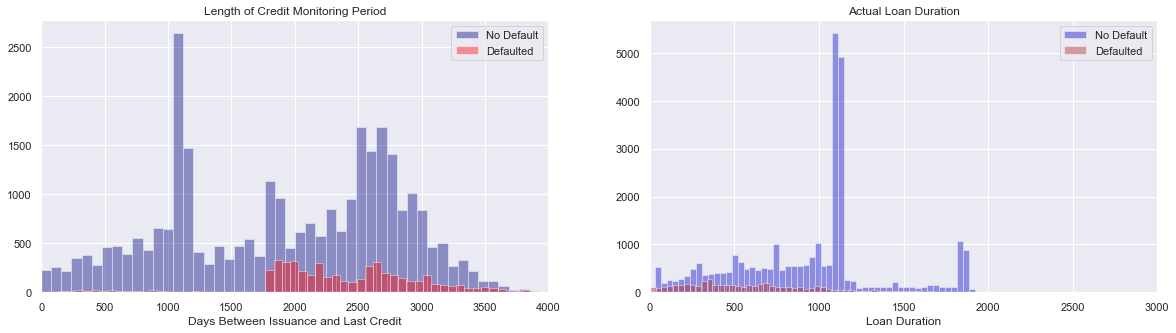

In [5]:
## Last Credit Pulled Date: Reverse causality
training["Days Between Issuance and Last Credit"] = training["Last Credit Pulled Date"] - training["Issued Date"]
training["Days Between Issuance and Last Credit"] = training["Days Between Issuance and Last Credit"].dt.days
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
sns.distplot(training.query("`Loan Status` == 0")["Days Between Issuance and Last Credit"], bins=60, color="navy", kde=False, label="No Default", ax=ax1)
sns.distplot(training.query("`Loan Status` == 1")["Days Between Issuance and Last Credit"], bins=60, color="red", kde=False, label="Defaulted", ax=ax1)
ax1.set_xlim(0,4000)
ax1.set_title("Length of Credit Monitoring Period")
ax1.legend()
# Juxtaposing against Actual Loan duration 
training["Loan Duration"] = (training["Last Payment Date"] - training["Issued Date"]).dt.days
sns.distplot(training.query("`Loan Status` == 0")["Loan Duration"],bins=60, color="mediumblue", kde=False, label="No Default", ax=ax2)
sns.distplot(training.query("`Loan Status` == 1")["Loan Duration"],bins=60, color="firebrick", kde=False, label="Defaulted", ax=ax2)
ax2.set_xlim(0,3000)
ax2.set_title("Actual Loan Duration")
ax2.legend()
training.drop(columns=["Loan Duration"], inplace=True)
training.drop(columns=["Days Between Issuance and Last Credit"], inplace=True)
plt.show();

#### Variables Based on Probability of Default

<span style=color:red>The above two variables should be excluded because their values conditioned on loans having concluded are correlated with default probability in ways their unconditioned are not. This means that even if we have time series data on the loans, they should be excluded when monitoring on-going loans.</span>

Some other variables are determined after the probability of default has been calculated. After initial calculations, they might be used in monitoring ongoing loans. But they should be excluded when pricing new loans. These include:

- `Loan Grade`, `Amount Funded`, `Interest Rate` and `Installment`. Lending Club assigns loan grade based on credit risk, and determines rate spread from loan grade. We shouldn't include them when pricing new loans. See loan grade - credit risk spread mapping at https://www.lendingclub.com/foliofn/rateDetail.action. Installment is determined from `Amount Funded` and `Interest Rate`.
- The `Funded Ratio`, defined as `Amount Funded` over `Loan Amount`. Lending Club very likely determines how much of the applied amount they should approve after assessing credit risk. Indeed, from our boostrap-based test, there is a statistically significant difference in `Funded Ratio` between default and non-defaulted loans. This suggests there's some relationship between whether a loan is deemed likely to default, and how much of the applied-for amount is approved. 
- Settlement-related data. No settlement plan should be set up before the loan has concluded. 

0
Loan Status          
0            0.985206
1            0.981430

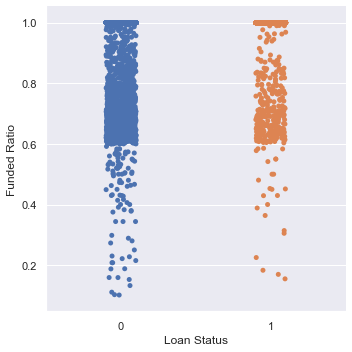

In [6]:
## Do defaulted loans have a lower funded ratio?
training["Funded Ratio"] = training["Funded Amount"]/training["Loan Amount"]
training["Fully Funded"] = (training["Funded Ratio"] == 1).astype(int)
sns.catplot(data=training, x="Loan Status", y="Funded Ratio", kind="strip")

# Check the funded ratio of two groups
training.groupby("Loan Status").apply(lambda x: x["Funded Ratio"].mean()).to_frame()

Bootstrap-based test on mean funded ratio:
Ttest_indResult(statistic=10.510883387224103, pvalue=7.925843723264319e-24)


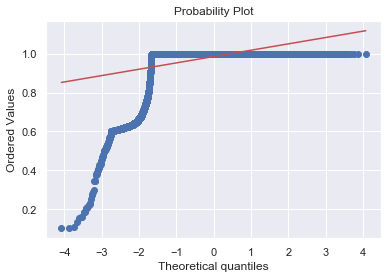

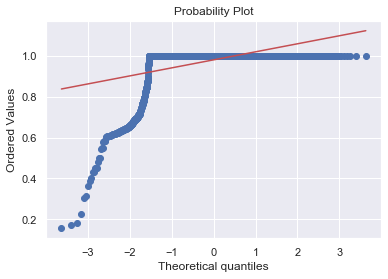

In [7]:
# An unpaired t-test
# Check varaince through Levene test. Two groups have different varaince. We do a Welch t-test.
stats.levene(training.query("`Loan Status` == 0")["Funded Ratio"], training.query("`Loan Status` == 1")["Funded Ratio"]) 

# Check normality. Clearly failed.
plt.figure()
stats.probplot(training.query("`Loan Status` == 0")["Funded Ratio"], dist="norm", plot = plt);
plt.figure()
stats.probplot(training.query("`Loan Status` == 1")["Funded Ratio"], plot = plt);


# Have to bootstrap the means.
def bootstrap_mean(series, num_of_times=300):
    n = series.size // 20
    means = []
    for i in range(num_of_times):
        sample = np.random.choice(series, size=n, replace=True)
        means.append(sample.mean())
    return np.array(means)

mean_funded_ratio_no_default = bootstrap_mean(training.query("`Loan Status` == 0")["Funded Ratio"])
mean_funded_ratio_default = bootstrap_mean(training.query("`Loan Status` == 1")["Funded Ratio"])

print("Bootstrap-based test on mean funded ratio:")
print(stats.ttest_ind(mean_funded_ratio_no_default, mean_funded_ratio_default))



#
# def welch_ttest(x, y): 
#     ## Welch-Satterthwaite Degrees of Freedom ##
#     dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
#     t, p = stats.ttest_ind(x, y, equal_var = False)
    
#     print("\n",
#           f"Welch's t-test= {t:.4f}", "\n",
#           f"p-value = {p:.4f}", "\n",
#           f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")


training.drop(columns=["Funded Ratio", "Fully Funded"], inplace=True)
plt.show();

#### Funded by Investors Ratio: an Exogenous Indicator of Market Confidence

While the actual `Amount Funded by Investors` isn't known until the loan application has been approved, and should therefore be removed, the proportion of each loan funded by investors is exogenous. When investors give their money to Lending Club, they explicitly indicate the range of loan paramters they are interested in (see https://help.lendingclub.com/hc/en-us/articles/216109777-How-do-investors-select-which-loans-to-invest-in-). Lending Club, being an intermediary rather than an actual risk taker, will pass _as much_ of the loans to investors _as possible_. <span style=color:red> This means that each loan's percentage funded by investor is determined by how much investor money is available for this type of loan. </span>

This availability reflects the market's overall interest in a certain risk basket. As the market might have information not present in our dataset, we think the `Ratio Funded by Investor` is worth including.

In [8]:
## Adding raiot funded by investor
def add_by_investor_ratio(lendingClub_df):
    lendingClub_df["Ratio Funded by Investor"] = lendingClub_df["Funded Amount Investor"] / lendingClub_df["Funded Amount"]
    return lendingClub_df

training.pipe(add_by_investor_ratio).head(2)
test.pipe(add_by_investor_ratio).head(2)

Loan Amount  Funded Amount  Funded Amount Investor        Term  \
0        35000          35000                 34975.0   60 months   
1         9500           9500                  9500.0   36 months   

   Interest Rate  Installment Grade Sub Grade  Loan Status Issued Date  \
0          11.71       773.44     B        B3            1  2011-11-01   
1          14.65       327.70     C        C3            0  2011-11-01   

                  Title                                        Description  \
0  Restaurant Inventory  Loan proceeds will be used to partially fund a...   
1   familyneeds my help  i need this money to help my family in Thailan...   

          Purpose          Employer Title Employment Length Home Ownership  \
0  small_business  US Department of Labor         10+ years       MORTGAGE   
1           other       costco wholesales         10+ years           RENT   

   Annual Income Verification Status Zip Code State  Debt-to-income Ratio  \
0       110000.0            Verified    945xx    CA                  1.06   
1        54000.0            Verified    334xx    FL                 17.69   

   Delinquencies in 2 years Earliest Credit Line  Inquiries in 6 months  \
0                         0           1971-01-01                      0   
1                         0           2001-05-01                      1   

   Months Since Last Delinquency  Months Since Last Public Record  \
0                              0                                0   
1                              0                                0   

   Open Accounts  Derogatory Public Records  Revolving Balance  \
0             10                          0               4142   
1              6                          0               5460   

   Revolving Balance Utilization  Number of Total Accounts  \
0                          0.064                        27   
1                          0.853                        11   

  Last Credit Pulled Date  Public Bankcruptcy Records  Total Payment  \
0              2017-07-01                           0       11601.60   
1              2018-10-01                           0        9616.54   

   Total Payment Investor  Total Received Principle  Total Received Interest  \
0                11593.34                      6927                  4652.28   
1                 9616.54                      9500                   116.54   

   Total Received Late Fee  Recoveries  Collection Recovery Fee  \
0                      0.0        22.5                      0.0   
1                      0.0         0.0                      0.0   

  Last Payment Date  Last Payment Amount Debt Settlement Flag  \
0        2013-02-01               773.44                    N   
1        2011-12-01              9616.95                    N   

  Debt Settlement Flag Date Settlement Status Settlement Date  \
0                       NaT               NaN             NaT   
1                       NaT               NaN             NaT   

   Settlement Amount  Settlement Percentage  Settlement Term  \
0                NaN                    NaN              NaN   
1                NaN                    NaN              NaN   

   Credit History Length in Months  Statewide Unemployment at Issuance  \
0                              490                                11.3   
1                              126                                 9.3   

   GDP Quarterly Growth at Issuance  3 Digit Zip Code  \
0                               4.7               945   
1                               4.7               334   

   Zipcode Level Unemployment Rate  Average Median Gross Rent  \
0                         8.176195                1425.191917   
1                         9.051832                1257.917039   

   Average Median House Value  Total Population  Per Capita Income  \
0               546049.175985         2025070.0       35498.327248   
1               278596.736273         1346327.0       33432.412351   

   

Loan Amount  Funded Amount  Funded Amount Investor        Term  \
0         5000           5000                  4975.0   36 months   
1         2500           2500                  2500.0   60 months   

   Interest Rate  Installment Grade Sub Grade  Loan Status Issued Date  \
0          10.65       162.87     B        B2            0  2011-12-01   
1          15.27        59.83     C        C4            1  2011-12-01   

      Title                                        Description      Purpose  \
0  Computer        I need to upgrade my business technologies.  credit_card   
1      bike  I plan to use this money to finance the motorc...          car   

  Employer Title Employment Length Home Ownership  Annual Income  \
0   NOT PROVIDED         10+ years           RENT        24000.0   
1          Ryder          < 1 year           RENT        30000.0   

  Verification Status Zip Code State  Debt-to-income Ratio  \
0            Verified    860xx    AZ                 27.65   
1     Source Verified    309xx    GA                  1.00   

   Delinquencies in 2 years Earliest Credit Line  Inquiries in 6 months  \
0                         0           1985-01-01                      1   
1                         0           1999-04-01                      5   

   Months Since Last Delinquency  Months Since Last Public Record  \
0                              0                                0   
1                              0                                0   

   Open Accounts  Derogatory Public Records  Revolving Balance  \
0              3                          0              13648   
1              3                          0               1687   

   Revolving Balance Utilization  Number of Total Accounts  \
0                          0.837                         9   
1                          0.094                         4   

  Last Credit Pulled Date  Public Bankcruptcy Records  Total Payment  \
0              2018-10-01                           0    5863.155187   
1              2016-10-01                           0    1014.530000   

   Total Payment Investor  Total Received Principle  Total Received Interest  \
0                 5833.84                      5000                   863.16   
1                 1014.53                       456                   435.17   

   Total Received Late Fee  Recoveries  Collection Recovery Fee  \
0                      0.0         0.0                     0.00   
1                      0.0       122.9                     1.11   

  Last Payment Date  Last Payment Amount Debt Settlement Flag  \
0        2015-01-01               171.62                    N   
1        2013-04-01               119.66                    N   

  Debt Settlement Flag Date Settlement Status Settlement Date  \
0                       NaT               NaN             NaT   
1                       NaT               NaN             NaT   

   Settlement Amount  Settlement Percentage  Settlement Term  \
0                NaN                    NaN              NaN   
1                NaN                    NaN              NaN   

   Credit History Length in Months  Statewide Unemployment at Issuance  \
0                              323                                 8.8   
1                              152                                 9.8   

   GDP Quarterly Growth at Issuance  3 Digit Zip Code  \
0                               4.7               860   
1                               4.7               309   

   Zipcode Level Unemployment Rate  Average Median Gross Rent  \
0                         8.025425                 824.974347   
1                         9.854890                 767.542591   

   Average Median House Value  Total Population  Per Capita Income  \
0               214282.322580          129227.0       20242.393842   
1               122901.890272          219598.0       22949.021603   

   Ratio Funded by Investor  
0                     0.995  
1              

#### Text Data

We won't do any fancy text processing in this project. For text data, we either discard, or perform simple manipulations.

- Loan `Title` and `Employer Title` are too messy -- the former contains more than 18000 unique values, and it captures the same information as `Purpose` only with greater granularity. The latter has more than 25000 unique values. Discard for this project.
- `Description` into word count. An intersting paper shows there's non-monotonous relationship between length of description and default probability. We test whether such correlation exists.

In [9]:
## Discarding Loan Title and 
training["Title"].unique().size

## Discarding Employer Title
training["Employer Title"].unique().size

## Description into Word Count
def get_length(lst):
    if lst == 'nan':
        return 0
    else:
        return len(lst)
    
def add_desc_word_count(lendingClub_df):
    lendingClub_df["Description Length"] = lendingClub_df["Description"].astype(str).str.split(" ").apply(get_length)
    return lendingClub_df
    
training.pipe(add_desc_word_count).head(1)
test.pipe(add_desc_word_count).head(1)

18027

25281

Loan Amount  Funded Amount  Funded Amount Investor        Term  \
0        35000          35000                 34975.0   60 months   

   Interest Rate  Installment Grade Sub Grade  Loan Status Issued Date  \
0          11.71       773.44     B        B3            1  2011-11-01   

                  Title                                        Description  \
0  Restaurant Inventory  Loan proceeds will be used to partially fund a...   

          Purpose          Employer Title Employment Length Home Ownership  \
0  small_business  US Department of Labor         10+ years       MORTGAGE   

   Annual Income Verification Status Zip Code State  Debt-to-income Ratio  \
0       110000.0            Verified    945xx    CA                  1.06   

   Delinquencies in 2 years Earliest Credit Line  Inquiries in 6 months  \
0                         0           1971-01-01                      0   

   Months Since Last Delinquency  Months Since Last Public Record  \
0                              0                                0   

   Open Accounts  Derogatory Public Records  Revolving Balance  \
0             10                          0               4142   

   Revolving Balance Utilization  Number of Total Accounts  \
0                          0.064                        27   

  Last Credit Pulled Date  Public Bankcruptcy Records  Total Payment  \
0              2017-07-01                           0        11601.6   

   Total Payment Investor  Total Received Principle  Total Received Interest  \
0                11593.34                      6927                  4652.28   

   Total Received Late Fee  Recoveries  Collection Recovery Fee  \
0                      0.0        22.5                      0.0   

  Last Payment Date  Last Payment Amount Debt Settlement Flag  \
0        2013-02-01               773.44                    N   

  Debt Settlement Flag Date Settlement Status Settlement Date  \
0                       NaT               NaN             NaT   

   Settlement Amount  Settlement Percentage  Settlement Term  \
0                NaN                    NaN              NaN   

   Credit History Length in Months  Statewide Unemployment at Issuance  \
0                              490                                11.3   

   GDP Quarterly Growth at Issuance  3 Digit Zip Code  \
0                               4.7               945   

   Zipcode Level Unemployment Rate  Average Median Gross Rent  \
0                         8.176195                1425.191917   

   Average Median House Value  Total Population  Per Capita Income  \
0               546049.175985         2025070.0       35498.327248   

   Ratio Funded by Investor  Description Length  
0                  0.999286                  27

Loan Amount  Funded Amount  Funded Amount Investor        Term  \
0         5000           5000                  4975.0   36 months   

   Interest Rate  Installment Grade Sub Grade  Loan Status Issued Date  \
0          10.65       162.87     B        B2            0  2011-12-01   

      Title                                  Description      Purpose  \
0  Computer  I need to upgrade my business technologies.  credit_card   

  Employer Title Employment Length Home Ownership  Annual Income  \
0   NOT PROVIDED         10+ years           RENT        24000.0   

  Verification Status Zip Code State  Debt-to-income Ratio  \
0            Verified    860xx    AZ                 27.65   

   Delinquencies in 2 years Earliest Credit Line  Inquiries in 6 months  \
0                         0           1985-01-01                      1   

   Months Since Last Delinquency  Months Since Last Public Record  \
0                              0                                0   

   Open Accounts  Derogatory Public Records  Revolving Balance  \
0              3                          0              13648   

   Revolving Balance Utilization  Number of Total Accounts  \
0                          0.837                         9   

  Last Credit Pulled Date  Public Bankcruptcy Records  Total Payment  \
0              2018-10-01                           0    5863.155187   

   Total Payment Investor  Total Received Principle  Total Received Interest  \
0                 5833.84                      5000                   863.16   

   Total Received Late Fee  Recoveries  Collection Recovery Fee  \
0                      0.0         0.0                      0.0   

  Last Payment Date  Last Payment Amount Debt Settlement Flag  \
0        2015-01-01               171.62                    N   

  Debt Settlement Flag Date Settlement Status Settlement Date  \
0                       NaT               NaN             NaT   

   Settlement Amount  Settlement Percentage  Settlement Term  \
0                NaN                    NaN              NaN   

   Credit History Length in Months  Statewide Unemployment at Issuance  \
0                              323                                 8.8   

   GDP Quarterly Growth at Issuance  3 Digit Zip Code  \
0                               4.7               860   

   Zipcode Level Unemployment Rate  Average Median Gross Rent  \
0                         8.025425                 824.974347   

   Average Median House Value  Total Population  Per Capita Income  \
0                214282.32258          129227.0       20242.393842   

   Ratio Funded by Investor  Description Length  
0                     0.995                   7

In [10]:
# A Sanity Check on description length
training["Description Length"].value_counts().to_frame().sort_index()
# Those longer than 700 are actual descriptions!
list(training["Description"][training["Description Length"] > 700])

Description Length
1                 11604
2                   611
3                   385
4                   357
5                   408
..                  ...
698                   2
724                   1
746                   1
757                   1
784                   1

[421 rows x 1 columns]

['This loan will be used to pay off a Chase Credit Card with a high interest rate.  I currently pay over 500.00 a month on that card to accelerate paying it off so my new loan payment will be easily met and the difference will be applied on other debt.  I have full custody of my 15 year old son and I receive Social Security Disability payments on his behalf from my ex-wife.  My son will no longer be eligible for benefits when he turns 18.  I have created a budget to pay off all of my credit card debt in the next 3 years before my son turns 18.  I have a good stable job as a computer programmer professional.  I have been in the IT industry for 24 years.   If you have any questions, please don??t hesitate to ask.  Thank you very much.   One Inquiry was a Discover Personal loan that I wanted to use to pay off my Chase Credit card and one other card but the rate they were offering was not very good so I declined the offer.  The other inquiry was because I was looking into refinancing my ho

#### _Discarding Rows where Zip-code Level Data Isn't Available_

In both training and test set, about 10% of the entries don't have zipcode level data. The default proportion in both groups don't differ by more than 0.0005 in both datasets.

For this project only, we will discard the rows where zip-code level data isn't available. In a real world setting, we'd further reduce the number of the missing values a finer query of macro-economic variables. If zip-code level data still aren't available, we will build two separate models, one for entries that have such data, and the other one for entries that don't.

In [11]:
default_rate(test)
default_rate(test[~test["Zipcode Level Unemployment Rate"].isnull()])

default_rate(training)
default_rate(training[~training["Zipcode Level Unemployment Rate"].isnull()])

0.171737490570782

0.17541397698568623

0.13836675318748395

0.13879174821136386

In [12]:
features_not_in_prediction = ["Debt Settlement Flag", "Debt Settlement Flag Date", "Settlement Status", "Settlement Date", "Settlement Amount", 
                     "Settlement Term", "Settlement Percentage",
                     "Total Payment", "Total Payment Investor", "Total Received Principle", "Total Received Interest", 
                      "Total Received Late Fee", "Recoveries", "Collection Recovery Fee", "Last Payment Date", "Last Payment Amount",
                              "Last Credit Pulled Date", "Earliest Credit Line",
                     "Interest Rate", "Installment", "Funded Amount", "Funded Amount Investor", "Grade", "Sub Grade", "Title", "Description",
                              "Employer Title",
                              "Zip Code", "3 Digit Zip Code"
                             ]
training_pred = training.drop(columns=features_not_in_prediction)
training_pred = training_pred[~training["Zipcode Level Unemployment Rate"].isnull()]
test_pred = test.drop(columns=features_not_in_prediction)
test_pred = test_pred[~test["Zipcode Level Unemployment Rate"].isnull()]
training_pred.head()

Loan Amount        Term  Loan Status Issued Date         Purpose  \
0        35000   60 months            1  2011-11-01  small_business   
1         9500   36 months            0  2011-11-01           other   
2         3800   36 months            1  2011-11-01             car   
4         4000   60 months            1  2011-11-01           other   
5         7500   36 months            0  2011-11-01         medical   

  Employment Length Home Ownership  Annual Income Verification Status State  \
0         10+ years       MORTGAGE       110000.0            Verified    CA   
1         10+ years           RENT        54000.0            Verified    FL   
2          < 1 year       MORTGAGE        47000.0     Source Verified    NY   
4           4 years           RENT        45000.0     Source Verified    FL   
5            1 year           RENT       210000.0     Source Verified    NY   

   Debt-to-income Ratio  Delinquencies in 2 years  Inquiries in 6 months  \
0                  1.06                         0                      0   
1                 17.69                         0                      1   
2                 22.52                         0                      3   
4                  7.37                         0                      0   
5                  3.70                         0                      0   

   Months Since Last Delinquency  Months Since Last Public Record  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
4                             50                                0   
5                              0                                0   

   Open Accounts  Derogatory Public Records  Revolving Balance  \
0             10                          0               4142   
1              6                          0               5460   
2             10                          0               8100   
4             10                          0               4786   
5             10                          0              15610   

   Revolving Balance Utilization  Number of Total Accounts  \
0                          0.064                        27   
1                          0.853                        11   
2                          0.393                        41   
4                          0.825                        13   
5                          0.358                        19   

   Public Bankcruptcy Records  Credit History Length in Months  \
0                           0                              490   
1                           0                              126   
2                           0                              113   
4                           0                              105   
5                           0                              210   

   Statewide Unemployment at Issuance  GDP Quarterly Growth at Issuance  \
0                                11.3                               4.7   
1                                 9.3                               4.7   
2                                 8.5                               4.7   
4                                 9.3                               4.7   
5                                 8.5                               4.7   

   Zipcode Level Unemployment Rate  Average Median Gross Rent  \
0                         8.176195                1425.191917   
1                         9.051832                1257.917039   
2                         7.767277                 684.311654   
4                         8.273617                1163.198755   
5                         8.178403                1294.773761   

   Average Median House Value  Total Population  Per Capita Income  \
0               546049.175985         2025070.0       35498.327248   
1               278596.736273         1346327.0       33432.412351   
2         

In [13]:
features_not_significant = ["Issued Date", "Description Length"]

### 2.1.2 Loan Condition:

We start with `Loan Amount`, then incrementally test the addition of following:

- `Term`
- `Issued Date`
- `Description Length`
- `Purpose`

__Term__

From boxen plots (fancier boxplots that show more quantile) below, we can see that 5-year loans generally have a bigger loan size than 3-year loans. Yet `Loan Size` doesn't fully capture `Term`'s impact on probability default: the p-value for null $H_0: logit(p_i) = \beta_0 + \beta_1 LoanAmount_i$ against alternative $H_1: logit(p_i) = \beta_0 + \beta_1 LoanAmount_i + \beta_2 I_{term=36, i}$ is almost 0. 

We thus include `Term` as a input variable.

Text(0.5, 1, 'Default Rate by Term \n 3-year: 10.7%, 5-year: 22.1%')

Default Rate
Term                    
 36 months      0.108327
 60 months      0.221678

Text(0.5, 1, 'Loan Amount by Term')

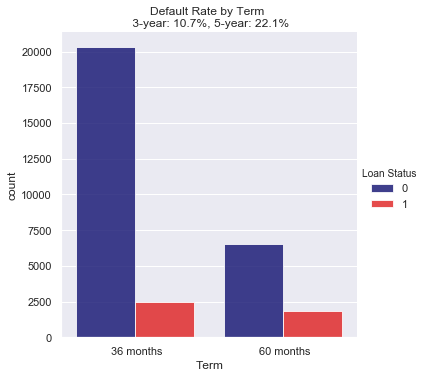

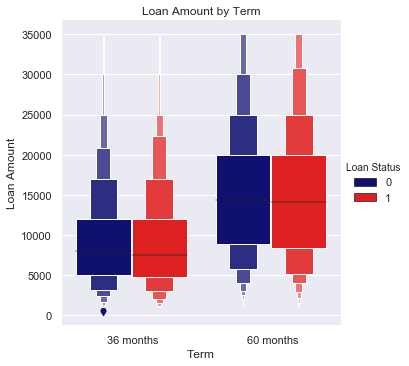

In [14]:
## Does Term matter?
# Default rate by loan term. Default rate for longer term loans is significantly higher.
sns.catplot(data=training_pred, x="Term", hue="Loan Status", kind="count", palette={1: "red", 0: "navy"}, order=training_pred["Term"].value_counts().index, alpha=0.8)
plt.title("Default Rate by Term \n 3-year: 10.7%, 5-year: 22.1%")

default_by_term = training_pred.groupby("Term").apply(default_rate).to_frame()
default_by_term.columns = ["Default Rate"]
default_by_term

# Can it be explained by Loan Size / Interest Rate?
# 60-month loans on average have larger size and higher interest rate.
np.random.seed(123)
index = np.random.choice(training_pred.shape[0], size=training_pred.shape[0]//30, replace=False)
g = sns.catplot(data=training_pred, x="Term", y="Loan Amount", hue="Loan Status", palette={1: "red", 0: "navy"}, kind="boxen", order=training_pred["Term"].value_counts().index)
g.ax.set_title("Loan Amount by Term")

In [15]:
## Continued on Term.
# A self-defined ANOVA test.
def extract_log_lik_summary(summary):
    logLik = summary.tables[0].data[4][3]
    return int(logLik[:-1])

def extract_num_of_parameters(summary):
    return len(summary.tables[1].data) - 1

# m1 is supposed to be the sub model, and m2 the full model
def anova_logistics(m1, m2):
    summary1 = m1.fit().summary()
    summary2 = m2.fit().summary()
    nop1 = extract_num_of_parameters(summary1)
    nop2 = extract_num_of_parameters(summary2)
    twice_neg_logLik1 = -2 * extract_log_lik_summary(summary1)
    twice_neg_logLik2 = -2 * extract_log_lik_summary(summary2)
    test_statistic = twice_neg_logLik1 - twice_neg_logLik2
    # number of paramters being tested
    ddof = nop2 - nop1
    pvalue = 1 - stats.chi2.cdf(test_statistic, ddof)
    result = {
        "test-statistic" : test_statistic,
        "p-value": pvalue
    }
    print("Summary of ANOVA on logistics regression using likelihood ratio:")
    print(result)
#     return result

# Let's do an anova test on two logistics regression: one including Loan Amount, Loan Status, the other one with the addition of Term
df = training_pred.copy(deep=True)
df.drop(columns="Issued Date", inplace=True)
df.columns = df.columns.str.replace(" ", "_")
# ANOVA for two models
endog = df["Loan_Status"]
exog1 = df.loc[:,["Loan_Amount"]]
exog1 = sm.add_constant(exog1)
exog2 = df.loc[:,["Loan_Amount", "Term"]]
exog2 = sm.add_constant(exog2)
exog2 = pd.get_dummies(exog2, prefix=["Term"]).drop(columns=["Term_ 60 months"])
m1 = sm.GLM(endog, exog1, family=sm.families.Binomial())
m2 = sm.GLM(endog, exog2, family=sm.families.Binomial())
# fit1 = sm.GLM(formula='Loan_Status ~ Loan_Amount + Interest_Rate', data=df, family=sm.families.Binomial())
anova_logistics(m1,m2)

Summary of ANOVA on logistics regression using likelihood ratio:
{'test-statistic': 552, 'p-value': 0.0}


C:\Users\nleea\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


__Issued Date__

Is a loan more likely to default just because it's issued later? That causality seems spurious at other. Yet `Issued Date` can be correlated with default probability through variables that reflect changing circumstances, such as macro-economic variables or indices for borrower's financial health. 

Below we plot the proportion of defaulted loans issued at each date, overlayed with the monthly GDP growth. Most of the climbs in default rate lag behind an increase in GDP growth by about 2-3 months, and typically coincide with either a flattening or downturn in the latter. A possible cause is that during the expansion stage of the economic cycle, Lending Club expands its businesses by lending to less credit-worthy borrowers. As growth tapers off, these borrwers start to default. 

All variables in our dataset has some fluctuation as `Issued Date` progresses. It's hard to explain how `Issued Date` affects default probability after accounting for all other variables. Thus, we won't include `Issued Date`.

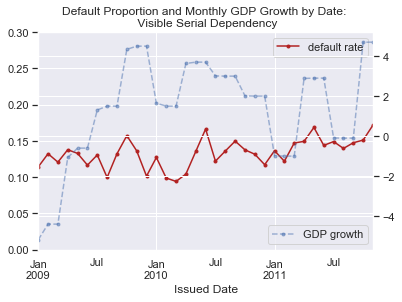

In [16]:
## Does Issued Date matter?
fig = plt.figure()
ax1 = fig.add_subplot()
default_by_issued_date = training_pred[training_pred["Issued Date"] > "2008-12-01"].groupby("Issued Date").apply(default_rate).to_frame()
default_by_issued_date.columns = ["default rate"]
default_by_issued_date.plot(ax=ax1, kind="line", color="firebrick", marker=".")
plt.ylim(0,0.3)

# Overlaying with the number of loans

ax2 = ax1.twinx()
# num_of_loan_issued_date = training_pred[training_pred["Issued Date"] > "2008-12-01"].groupby("Issued Date").size().to_frame()
# num_of_loan_issued_date.columns = ["Number of Loans"]
# num_of_loan_issued_date.plot(ax=ax2, kind="line", style="--", color="firebrick", alpha=0.7);
gdp_growth = training_pred[training_pred["Issued Date"] > "2008-12-01"].groupby("Issued Date").apply(lambda x: x["GDP Quarterly Growth at Issuance"].mean()).to_frame()
gdp_growth.columns = ["GDP growth"]
gdp_growth.plot(ax=ax2, kind="line", style="--", alpha=0.5, marker=".")
plt.title("Default Proportion and Monthly GDP Growth by Date: \n Visible Serial Dependency")

training_pred["Issued Date"].value_counts().to_frame().head();
plt.show();

__Description Length__

About 35.1% of the applicants didn't provide a description. Another 61.0% wrote a short descriptions with fewer than 140 words. A handful or borrowers do provide a lengthy descriptions with length exceeding 700 words, and none of them defaulted.

We plot the number of loans at each description length, and overlay it with the in-sample default proportion. Most bins after 200 contain fewer than 150 samples, a size we deem too small for the default proportion to be a meaningful reference of default probability. 

Focusing on the first seven bins, we don't see any significant fluctuation in default probability. We therefore consider `Description Length` irrelavent.

In [17]:
## Description Length
training_pred["Description Length Bin"] = pd.cut(training_pred["Description Length"], bins=np.r_[0,np.arange(1, 702, 35)])
(training_pred["Description Length Bin"].value_counts().cumsum().to_frame()/training_pred["Description Length Bin"].shape[0]).head(5)

Description Length Bin
(1, 36]                   0.350829
(0, 1]                    0.681318
(36, 71]                  0.854760
(71, 106]                 0.926177
(106, 141]                0.960313

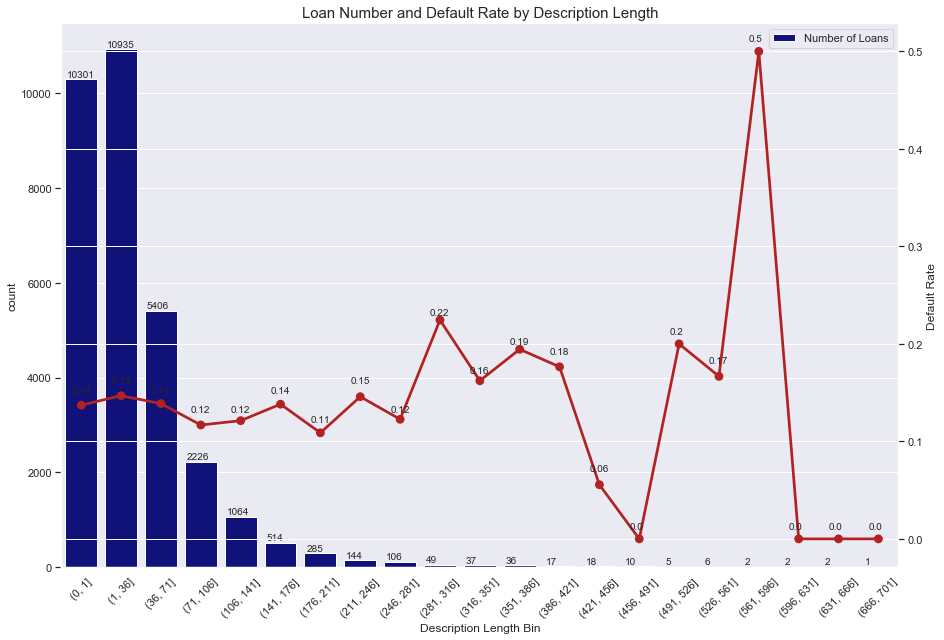

In [18]:
# Plot default proportion against each description length range.
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot()
sns.countplot(data=training_pred, x="Description Length Bin", ax=ax1, color="darkblue", label="Number of Loans")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
   
# Overlaying the graph with default rate
default_by_description_length = training_pred.groupby("Description Length Bin").apply(default_rate).to_frame()
default_by_description_length.columns = ["Default Rate"]
default_by_description_length.reset_index(inplace=True)
ax2 = ax1.twinx()
sns.pointplot(data=default_by_description_length, x="Description Length Bin", y="Default Rate", ax=ax2, color="firebrick",
           style="--", alpha=0.5, label="Default Rate")
ax1.set_title("Loan Number and Default Rate by Description Length", fontsize=15)

i = 0
for p in ax1.patches:
    ax1.annotate(p.get_height(), (p.get_x() + 0.05, p.get_height() + 50))
    default_prop = np.round(default_by_description_length.loc[i, "Default Rate"], 2)
    ax2.annotate(default_prop, (p.get_x() + 0.15, default_prop + 0.01))
    i += 1

training_pred.drop(columns = "Description Length Bin", inplace=True)
ax1.legend()
plt.show();

__Purpose__

Default proportions fluctuate significantly between different purposes, but the distribution of loan size and terms do not vary significantly between purpose groups. This means that `Purpose` contributes independently towards default rate. 

One problem is that there are 14 categories in `Purpose`. Turning on one-hot encoding for all of them might add too many paramters and lead to overfitting. We tried reducing the number of categories by re-grouping all purposes into `wants_to`, `has_to` and `other`, holding the belief that people who `want_to` take on loans might have a better financial condition (and thus a lower default rate) by self-selection. However the theory isn't supported by data: default probability between three groups show no significant difference. 

We thus retain `Purpose` as is.

In [19]:
## Purpose matters?
purpose_count = training_pred["Purpose"].value_counts().to_frame()
purpose_count.shape

(14, 1)

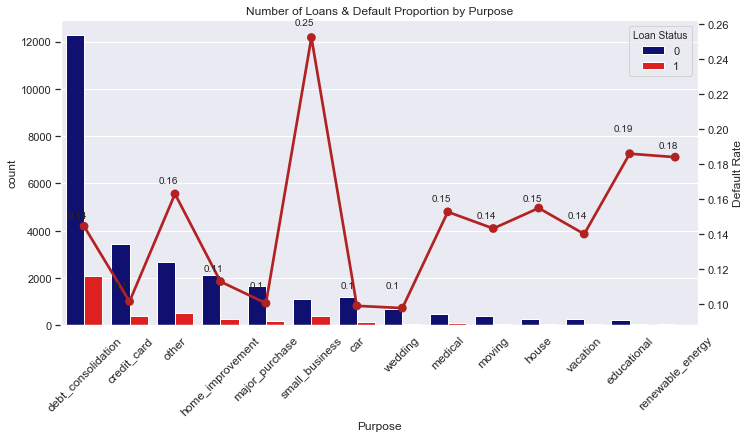

In [20]:
## Purpose matters?
g = sns.catplot(data=training_pred, x="Purpose", kind="count", hue="Loan Status", palette={1: "red", 0: "navy"}, height=5, aspect=2,
               order=training_pred["Purpose"].value_counts().index, legend_out=False)
g.set_xticklabels(rotation=45, fontsize='large')
ax1 = g.ax
## the twinx method is very useful
ax2 = g.ax.twinx()
default_by_purpose = training_pred.groupby("Purpose").apply(default_rate).to_frame()
default_by_purpose = default_by_purpose.reindex(purpose_count.index)
default_by_purpose.reset_index(inplace=True)
default_by_purpose.columns = ["Purpose", "Default Rate"]
sns.pointplot(data=default_by_purpose, x="Purpose", y="Default Rate", kind="point", ax=ax2, 
              order=training_pred["Purpose"].value_counts().index, color="firebrick")
ax2.grid(False)

for i in range(int(len(ax1.patches)/2)):
    p = ax1.patches[i]
#     ax1.annotate(purpose_count["Purpose"][i], (p.get_x() + 0.2, p.get_height() + 50), fontsize=10)
    default_proportion = np.round(default_by_purpose["Default Rate"][i], 2)
    ax2.annotate(default_proportion, (p.get_x()+0.04, default_proportion + 0.009))
    i += 1

plt.title("Number of Loans & Default Proportion by Purpose")    
plt.show();

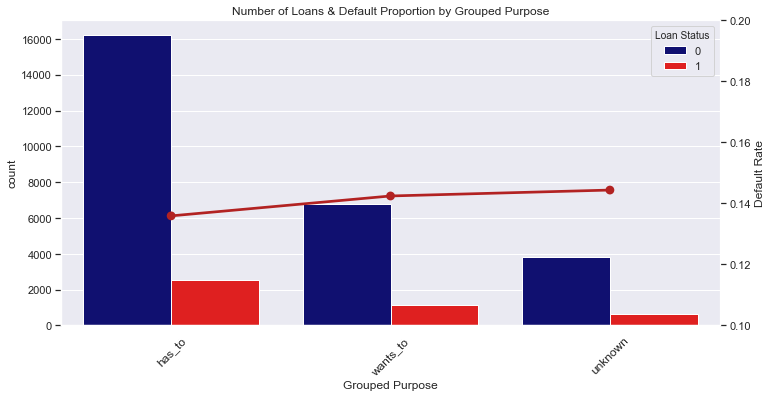

In [21]:
## Purpose
# What if we further group the purpose?
has_to = ['medical', 'debt_consolidation', 'credit_card']
wants_to = ['home_improvement', 'major_purchase', 'wedding','house', 'vacation', 'moving', 'renewable_energy', 'educational', 'small_business']
unknown = ['other']
def group_purpose(purpose):
    if purpose in has_to:
        return 'has_to'
    elif purpose in wants_to:
        return 'wants_to'
    else:
        return 'unknown'
    
def add_grouped_purpose(lendingClub_df):
    lendingClub_df["Grouped Purpose"] = lendingClub_df["Purpose"].apply(group_purpose)
    return lendingClub_df

training_pred.pipe(add_grouped_purpose)

## Purpose
# Grouped purpose
purpose_grouped_count = training_pred["Grouped Purpose"].value_counts().to_frame()
purpose_grouped_count
## Purpose matters?
g = sns.catplot(data=training_pred, x="Grouped Purpose", kind="count", hue="Loan Status", palette={1: "red", 0: "navy"}, height=5, aspect=2,
               order=training_pred["Grouped Purpose"].value_counts().index, legend_out=False)
g.set_xticklabels(rotation=45, fontsize='large')
ax1 = g.ax
## the twinx method is very useful
ax2 = g.ax.twinx()
default_by_grouped_purpose = training_pred.groupby("Grouped Purpose").apply(default_rate).to_frame()
default_by_grouped_purpose = default_by_grouped_purpose.reindex(purpose_grouped_count.index)
default_by_grouped_purpose.reset_index(inplace=True)
default_by_grouped_purpose.columns = ["Grouped Purpose", "Default Rate"]
sns.pointplot(data=default_by_grouped_purpose, x="Grouped Purpose", y="Default Rate", kind="point", ax=ax2, 
              order=training_pred["Grouped Purpose"].value_counts().index, color="firebrick")
ax2.set_ylim(0.1,0.2)
ax2.grid(False)

plt.title("Number of Loans & Default Proportion by Grouped Purpose")

training_pred.drop(columns = ["Grouped Purpose"], inplace=True)
plt.show();

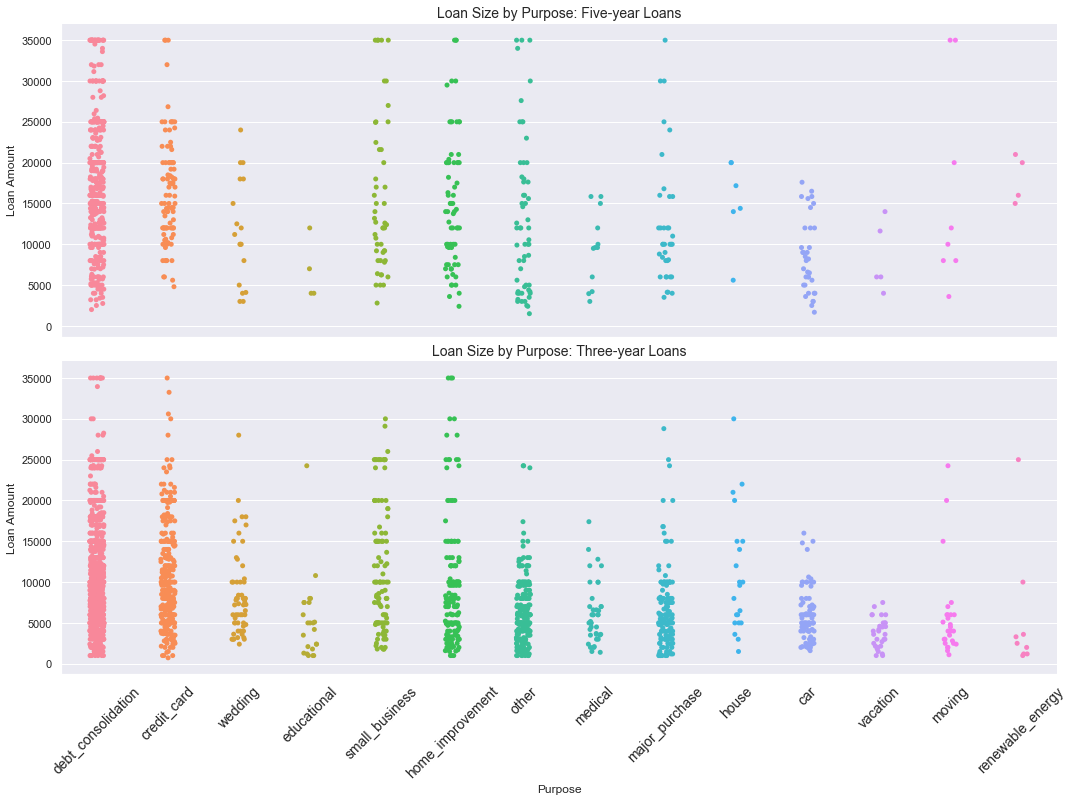

In [22]:
## Purpose against Loan Size and Term
np.random.seed(123)
index = np.random.choice(training_pred.shape[0], size=training_pred.shape[0]//10)
g = sns.catplot(data=training_pred.iloc[index, :], x="Purpose", y="Loan Amount", kind="strip", row="Term", height=5, aspect=3)
g.set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45, fontsize=14)
g.axes[0][0].set_title("Loan Size by Purpose: Five-year Loans", fontsize=14)
g.axes[1][0].set_title( "Loan Size by Purpose: Three-year Loans", fontsize=14)
plt.show();

In [23]:
## Purpose
exog3 = pd.concat([exog2, pd.get_dummies(training_pred["Purpose"]).drop(columns='wedding')], axis=1)
m3 = sm.GLM(endog, exog3, family=sm.families.Binomial())
anova_logistics(m2, m3)

Summary of ANOVA on logistics regression using likelihood ratio:
{'test-statistic': 276, 'p-value': 0.0}


### 2.1.3 Borrower Financial Condition

We start with `Annual Income` and `Debt-to-income Ratio`, and assess the data quality based on `Verification Status`. Then we incrementally test the following:

- `Home Ownership`, `Average Median House Value`, `Average Median Gross Rent`
- `Employment Length`
- `State`

__Annual Income__

__Outliers: Are borrowers lying when their high income can't be verified?__

About 0.18% of borrowers have an income higher than 500,000 dollars. We plot these outliers inferred age (the mean age for people getting their first line of credit in the US is 19. We simply add that to the length of credit history) against their claimed annual income, colored by their homeownership status, with a larger size indicating default.

Among the 56 individuals earning more than 500,000, only 11 have their income verified. Among the unverified group, 9 are under 30, and still renting a house. We think it's almost impossible that people can have exhibited such growth potential in career yet fail to consider buying a house. We remove these entries.

(0, 500000)

0.16071428571428573

0.0017966569347749367

C:\Users\nleea\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(450000, 2000000)

Text(0.5, 1, 'Inferred Age vs Annual Income')

C:\Users\nleea\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


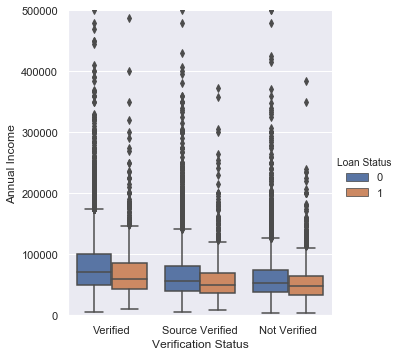

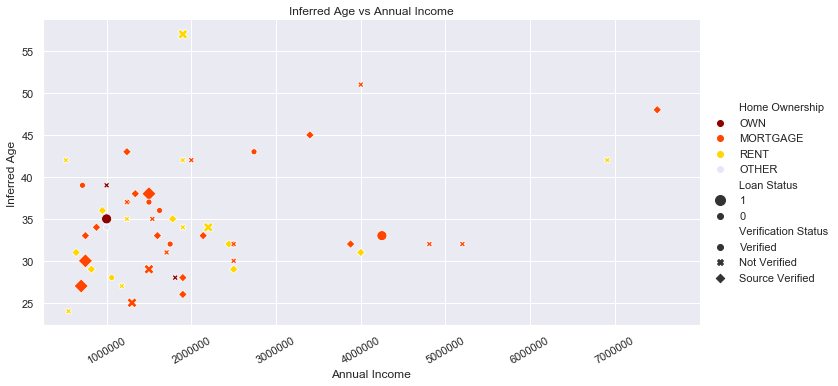

In [24]:
## Annual Income
g = sns.catplot(data=training_pred, x="Verification Status", y="Annual Income", kind="box", hue="Loan Status")
g.ax.set_ylim(0,500000)
# Outliers
outliers = training_pred.query("`Annual Income` > 500000")
default_rate(outliers)
training_pred.query("`Annual Income` > 500000").shape[0]/training_pred.shape[0]
outliers["Inferred Age"] = outliers["Credit History Length in Months"] // 12 + 19

## Outliers
g = sns.relplot(data=outliers, x="Annual Income", y="Inferred Age", hue="Home Ownership", palette={"OWN": "darkred", "MORTGAGE": "orangered", 
                                                                                                                "RENT": "gold", "OTHER": "lavender"},
                hue_order = ["OWN", "MORTGAGE", "RENT", "OTHER"],
           style="Verification Status", markers={"Verified": "o", "Not Verified": 'X', "Source Verified": "D"}, size="Loan Status",
               size_order=[1, 0], sizes=[100,36], height=5, aspect=2)
g.ax.set_xlim(450000, 2000000)
g.set_xticklabels(rotation=30)
g.ax.set_title("Inferred Age vs Annual Income")
removed = outliers[outliers["Verification Status"] != "Verified"][outliers["Home Ownership"] == "RENT"][outliers["Inferred Age"] < 35]
training_pred.drop(index=removed.index, inplace=True)

__Verification Status__

Different verification status groups do exhibit different default probabilities. Yet countrary to common belief, both source verified and unverified incomes are lower than the verified group in distribution, and it is the verified group that has the highest default rate. A possible explanation is that borrowers with verifiable income tend to apply for a bigger loan, which has a greater chance of defaulting.

We add an interaction term between income and verification status to reflect such dependency. Explicitly the model is:

$$logit(p_i) = \beta_0 + \beta_1 \cdot dti + \beta_{2}Income + \beta_{3}Income \cdot I_{Unverified} + \beta_4 \cdot I_{Source Verified}$$

The model has the following property:

$$\frac{\partial logit(p_i)}{\partial Income}|\text{Income is verified} = \beta_2$$

while

$$\frac{\partial logit(p_i)}{\partial Income}|\text{Income is unverified} = \beta_2 + \beta_3$$

and

$$\frac{\partial logit(p_i)}{\partial Income}|\text{Income is source verifified} = \beta_2 + \beta_4$$

Note we only add the interaction term but not the indicators by themselves. This says different income verfication status only impact the default probability through changing income's contribution, but not by itself.

In [25]:
training_pred["Verification Status"].value_counts().to_frame()

Verification Status
Not Verified                   13259
Verified                       10063
Source Verified                 7838

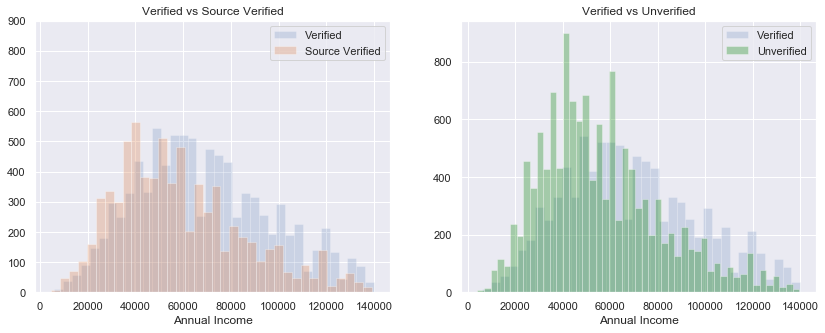

In [26]:
training_pred["Annual Income"].quantile(0.95)
training_income95 = training_pred.query("`Annual Income` < 140000")
fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)
sns.distplot(training_income95[training_income95["Verification Status"] == "Verified"]["Annual Income"], kde=False, label="Verified", hist_kws=dict(alpha=0.2), ax=ax1)
sns.distplot(training_income95[training_income95["Verification Status"] == "Source Verified"]["Annual Income"], kde=False, label="Source Verified", ax=ax1, hist_kws=dict(alpha=0.3))
# sns.distplot(training_income95[training_income95["Verification Status"] == "Not Verified"]["Annual Income"], kde=False, label="Unverified", ax=ax, hist_kws=dict(alpha=0.3))
ax1.set_ylim(0,900)
ax1.set_title("Verified vs Source Verified")
plt.legend()

ax2 = plt.subplot(122)
sns.distplot(training_income95[training_income95["Verification Status"] == "Verified"]["Annual Income"], kde=False, label="Verified", hist_kws=dict(alpha=0.2), ax=ax2)
sns.distplot(training_income95[training_income95["Verification Status"] == "Not Verified"]["Annual Income"], kde=False, label="Unverified", ax=ax2, hist_kws=dict(alpha=0.3), color="green")
ax2.set_title("Verified vs Unverified")
plt.legend()
plt.show();

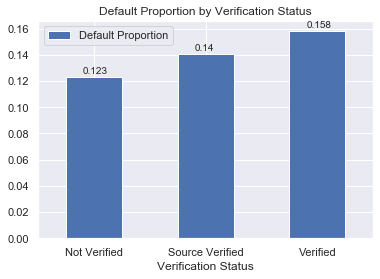

In [41]:
## Are unverified group more likely to default?
ax = training_pred.groupby("Verification Status").apply(default_rate).to_frame().rename(columns={0:"Default Proportion"}).plot(kind="bar", label="default proportion")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("Default Proportion by Verification Status")
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), 3), (p.get_x()+0.15, p.get_height()+0.003))

plt.show();

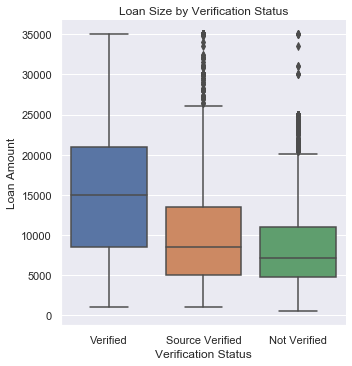

In [42]:
## Verfication Status. Why?
sns.catplot(data=training_pred, x="Verification Status", y="Loan Amount", kind="box")
plt.title("Loan Size by Verification Status")
plt.show();

In [29]:
# Adding predictor
exog3 = exog3.loc[training_pred.index, :]
endog = endog[training_pred.index]
temp = pd.get_dummies(training_pred["Verification Status"]).drop(columns="Verified")
temp["Not Verified"] *= training_pred["Annual Income"]
temp["Source Verified"] *= training_pred["Annual Income"]
exog4 = pd.concat([training_pred["Annual Income"], temp, training_pred["Debt-to-income Ratio"]], axis=1)
exog4 = sm.add_constant(exog4)
m4 = sm.GLM(endog, exog4, family=sm.families.Binomial())
m4.fit().summary()

C:\Users\nleea\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                31160
Model:                            GLM   Df Residuals:                    31155
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12458.
Date:                Mon, 09 Dec 2019   Deviance:                       24916.
Time:                        14:21:03   Pearson chi2:                 3.46e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.6722      0.051    -32.936      0.000      -1.772      -1.573
Annual Income         -2.86e-06   4.76e-07     -6.005      0.000   -3.79e-06   -1.93e-06
Not Verified         -4.449e-06   5.66e-07     -7.864      0.000   -5.56e-06   -3.34e-06
Source Verified      -1.478e-06   5.69e-07     -2.597      0.009   -2.59e-06   -3.62e-07
Debt-to-income Ratio     0.0118      0.002      4.779      0.000       0.007       0.017
========================================================================================
"""

__Home Ownership__

85 entries in the training set have "other" type of `Home Ownership`, but no entries in the test set do. This means during prediction our model doesn't have to care about that home ownership type. We remove these entries.

Interestingly the group on a mortgage have the least default proportion. 

We try to detail the impact of home ownership through property values. The logic is simple: someone owning a mortgage on a 3 million house probably has a bigger debt burden than on a 300,000 house. We achieve that again through the indicator trick:

$$logit(p_i) = \beta_0 + ... + \beta_{Mortgage}\cdot I_{Mortgage} \cdot \text{Housing Price} + \beta_{Rent} \cdot I_{Rent} \cdot \text{Rent} 
+ \beta_{Own} \cdot I_{Own} \cdot \text{Housing Price}$$

Liklihood ratio test shows these newly added terms are statistically significant. We add them to the roster.

In [43]:
## Home Ownership count
training_pred["Home Ownership"].value_counts().to_frame()
training_pred = training_pred[training_pred["Home Ownership"] != "OTHER"]
# update dataframes used for statsmodel 
exog3 = exog3.loc[training_pred.index, :]
exog4 = exog4.loc[training_pred.index, :]
endog = endog[training_pred.index]

Home Ownership
RENT               14382
MORTGAGE           14313
OWN                 2380

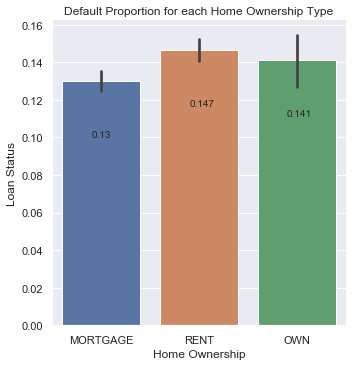

In [44]:
# Default proportion by purpose
g = sns.catplot(data=training_pred, x="Home Ownership", y="Loan Status", kind="bar")
for p in g.ax.patches:
    g.ax.annotate(np.round(p.get_height(), 3), (p.get_x()+0.3, p.get_height()-0.03))
plt.title("Default Proportion for each Home Ownership Type")
plt.show();

In [32]:
# Checking how significant
temp2 = pd.get_dummies(training_pred["Home Ownership"])
temp2["MORTGAGE"] *= training_pred["Average Median House Value"]
temp2["OWN"] *= training_pred["Average Median House Value"]
temp2["RENT"] *= training_pred["Average Median Gross Rent"]
exog5 = pd.concat([exog4, temp2], axis=1)
# 
m5 = sm.GLM(endog, exog5, family=sm.families.Binomial())
# m5.fit().summary()
anova_logistics(m4, m5)

Summary of ANOVA on logistics regression using likelihood ratio:
{'test-statistic': 88, 'p-value': 0.0}


__Employment Length__

About 80% of the variation in length of credit history are left unexplained by employment length. This means the correlation between two is weak, and we can't use one as proxy for the other.

To better utilize the contionus property of `Employment Length` we convert them into numerical values. < 1 year and 10+ years are converted to 0 and 10 years. We think such renaming is admissible as long as the rescaling effect is kept in mind. There are about 800 entries without employment length. We randomly fill the missing values with employment length from 0 to 10 years with equal probability.

The graph shows that borrowers with a longer employment history (points with deeper color) tend to have a higher annual income, a longer credit history, and apply for a larger loan. This phenomenon fits our common sense and provides some justification for our imputation. Plotting default proportion within each employment length group, we do observe some fluctuations. We then test the inclusion of employment length on the basis of income, dti and housing-price weighted home ownership, and the resulting coefficient is significant. 

We thus include employment length.

In [33]:
training_pred["Employment Length"].value_counts().to_frame().sort_index()

Employment Length
1 year                  2545
10+ years               6900
2 years                 3453
3 years                 3248
4 years                 2684
5 years                 2602
6 years                 1688
7 years                 1358
8 years                 1150
9 years                  976
< 1 year                3599

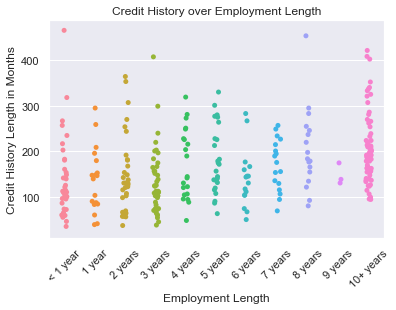

In [34]:
## Employment Length and Credit History
emp_length_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "8 years", "9 years",
                  "10+ years"]
index = np.random.choice(training_pred.shape[0], size=training_pred.shape[0]//100)
ax = sns.stripplot(data=training_pred.iloc[index, :], y="Credit History Length in Months", x="Employment Length", 
            order=["< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "8 years", "9 years",
                  "10+ years"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Credit History over Employment Length")
plt.show();

In [35]:
## How much of variation in credit history can be explained by employment length?
# Can any at all?
credit_histories = []
for emp_length in emp_length_order:
    credit_histories.append(training_pred[training_pred["Employment Length"] == emp_length]["Credit History Length in Months"])
stats.f_oneway(credit_histories[0], credit_histories[1], credit_histories[2], credit_histories[3], credit_histories[4], credit_histories[5],
              credit_histories[6], credit_histories[7], credit_histories[8], credit_histories[9], credit_histories[10])

# How much variation in credit history months can be explained by employment length? Not much.
total_var = np.var(training_pred["Credit History Length in Months"]) * training_pred["Credit History Length in Months"].size
grouped_var = 0
for group in credit_histories:
    grouped_var +=  np.var(group) * group.size
grouped_var/total_var

F_onewayResult(statistic=358.2649807008072, pvalue=0.0)

0.8137467140616467

In [36]:
## We turn employment length into numerical data by turning <1 to 0 and 10+ to 10
def format_emp_length(lendingClub_df):
    lendingClub_df["Employment Length"] = lendingClub_df["Employment Length"].fillna(np.random.choice(emp_length_order, size=1)[0])
    lendingClub_df["Employment Length"] = lendingClub_df["Employment Length"].str.replace("< 1 year", "0 years")
    lendingClub_df["Employment Length"] = lendingClub_df["Employment Length"].str.replace("1 year", "1 years")    
    lendingClub_df["Employment Length"] = lendingClub_df["Employment Length"].str[:2].str.strip().astype(int)
    return lendingClub_df


training_pred.pipe(format_emp_length)
test_pred.pipe(format_emp_length)

Loan Amount        Term  Loan Status Issued Date             Purpose  \
0            35000   60 months            1  2011-11-01      small_business   
1             9500   36 months            0  2011-11-01               other   
2             3800   36 months            1  2011-11-01                 car   
4             4000   60 months            1  2011-11-01               other   
5             7500   36 months            0  2011-11-01             medical   
...            ...         ...          ...         ...                 ...   
35054        12000   36 months            0  2007-12-01         credit_card   
35055        12375   36 months            0  2007-12-01  debt_consolidation   
35056         4800   36 months            0  2007-11-01  debt_consolidation   
35057         7000   36 months            0  2007-11-01  debt_consolidation   
35058         9000   36 months            1  2007-10-01  debt_consolidation   

       Employment Length Home Ownership  Annual Income Verification Status  \
0                     10       MORTGAGE      110000.00            Verified   
1                     10           RENT       54000.00            Verified   
2                      0       MORTGAGE       47000.00     Source Verified   
4                      4           RENT       45000.00     Source Verified   
5                      1           RENT      210000.00     Source Verified   
...                  ...            ...            ...                 ...   
35054                  6       MORTGAGE      100671.39        Not Verified   
35055                  2           RENT       80000.00        Not Verified   
35056                  1           RENT       35000.00        Not Verified   
35057                  3       MORTGAGE       63500.00        Not Verified   
35058                  8       MORTGAGE       39000.00        Not Verified   

      State  Debt-to-income Ratio  Delinquencies in 2 years  \
0        CA                  1.06                         0   
1        FL                 17.69                         0   
2        NY                 22.52                         0   
4        FL                  7.37                         0   
5        NY                  3.70                         0   
...     ...                   ...                       ...   
35054    IL                  6.64                         0   
35055    VA                  9.23                         0   
35056    VA                  7.51                         0   
35057    AZ                  8.50                         0   
35058    MD                  5.08                         0   

       Inquiries in 6 months  Months Since Last Delinquency  \
0                          0                              0   
1                          1                              0   
2                          3                              0   
4                          0                             50   
5                          0                              0   
...                      ...                            ...   
35054                      0                             62   
35055                      0                              0   
35056                      0                             52   
35057                      1                              0   
35058                      3                             60   

       Months Since Last Public Record  Open Accounts  \
0                                    0             10   
1                                    0              6   
2                                    0             10   
4                                    0             10   
5                                    0             10   
...                                ...            ...   
35054                              115             16   
35055                              103              4   
35056                              114             11   
35057                              11

Loan Amount        Term  Loan Status Issued Date             Purpose  \
0            5000   36 months            0  2011-12-01         credit_card   
1            2500   60 months            1  2011-12-01                 car   
2            2400   36 months            0  2011-12-01      small_business   
3           10000   36 months            0  2011-12-01               other   
4            3000   60 months            0  2011-12-01               other   
...           ...         ...          ...         ...                 ...   
3972         7450   36 months            0  2011-11-01             wedding   
3973        22000   36 months            0  2011-11-01      small_business   
3974         3250   36 months            0  2011-11-01         credit_card   
3975        10000   36 months            0  2011-11-01  debt_consolidation   
3976         4900   36 months            0  2011-11-01  debt_consolidation   

      Employment Length Home Ownership  Annual Income Verification Status  \
0                    10           RENT        24000.0            Verified   
1                     0           RENT        30000.0     Source Verified   
2                    10           RENT        12252.0        Not Verified   
3                    10           RENT        49200.0     Source Verified   
4                     1           RENT        80000.0     Source Verified   
...                 ...            ...            ...                 ...   
3972                  1       MORTGAGE        95000.0     Source Verified   
3973                 10       MORTGAGE       115000.0            Verified   
3974                 10       MORTGAGE        55000.0     Source Verified   
3975                  1           RENT       122500.0            Verified   
3976                  2       MORTGAGE        80000.0        Not Verified   

     State  Debt-to-income Ratio  Delinquencies in 2 years  \
0       AZ                 27.65                         0   
1       GA                  1.00                         0   
2       IL                  8.72                         0   
3       CA                 20.00                         0   
4       OR                 17.94                         0   
...    ...                   ...                       ...   
3972    CO                  6.61                         0   
3973    MO                  0.31                         0   
3974    MN                 10.71                         2   
3975    NY                  2.88                         0   
3976    IL                  8.07                         0   

      Inquiries in 6 months  Months Since Last Delinquency  \
0                         1                              0   
1                         5                              0   
2                         2                              0   
3                         1                             35   
4                         0                             38   
...                     ...                            ...   
3972                      1                             40   
3973                      0                              0   
3974                      1                             10   
3975                      2                              0   
3976                      3                              0   

      Months Since Last Public Record  Open Accounts  \
0                                   0              3   
1                                   0              3   
2                                   0              2   
3                                   0             10   
4                                   0             15   
...                               ...            ...   
3972                                0             13   
3973                                0              9   
3974                                0             17   
3975                                0              8   
3976                                0 

Text(0.5, 1.0, 'Employment Length over Credit History and Annual Income')

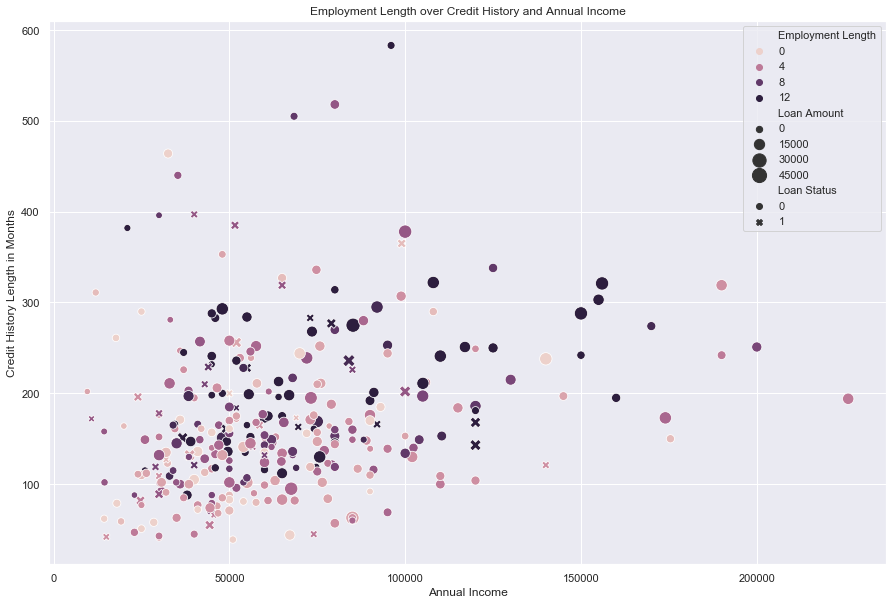

In [70]:
## Sanity Check: How does employment length relate to income?
np.random.seed(121)
index = np.random.choice(training_pred.shape[0], size=training_pred.shape[0]//100)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.scatterplot(data=training_pred.iloc[index,:], y="Credit History Length in Months", x="Annual Income", hue="Employment Length", size="Loan Amount",
           style="Loan Status", markers={0:"o", 1:"X"}, ax=ax, sizes=(40,200))
plt.title("Employment Length over Credit History and Annual Income")

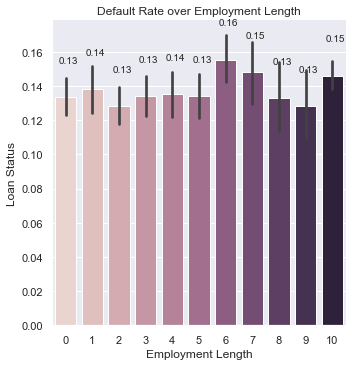

In [81]:
## Employment Length influences Default Rate?
g = sns.catplot(data=training_pred, x="Employment Length", y="Loan Status",kind="bar", palette=sns.cubehelix_palette(11))
for p in g.ax.patches:
    g.ax.annotate(np.round(p.get_height(), 2), (p.get_x()+0.15, p.get_height()+0.02))
plt.title("Default Rate over Employment Length")
plt.show();

In [45]:
##
exog6 = pd.concat([exog5, training_pred["Employment Length"]], axis=1)
m6 = sm.GLM(endog, exog6, family=sm.families.Binomial())
m6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                31075
Model:                            GLM   Df Residuals:                    31066
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12406.
Date:                Mon, 09 Dec 2019   Deviance:                       24813.
Time:                        15:17:18   Pearson chi2:                 3.50e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.8450      0.068    -27.062      0.000      -1.979      -1.711
Annual Income        -3.081e-06   5.14e-07     -5.995      0.000   -4.09e-06   -2.07e-06
Not Verified         -4.408e-06   5.68e-07     -7.762      0.000   -5.52e-06   -3.29e-06
Source Verified      -1.413e-06   5.71e-07     -2.474      0.013   -2.53e-06   -2.94e-07
Debt-to-income Ratio     0.0115      0.002      4.615      0.000       0.007       0.016
MORTGAGE              2.097e-07   1.66e-07      1.264      0.206   -1.15e-07    5.35e-07
OWN                   3.204e-07   2.22e-07      1.444      0.149   -1.15e-07    7.55e-07
RENT                     0.0001   4.28e-05      2.811      0.005    3.64e-05       0.000
Employment Length        0.0192      0.005      3.916      0.000       0.010       0.029
========================================================================================
"""

__State__

Lending Club's biggest presence is in costal states: California, New York, Florida and Texas account for more tha 46% of its entire loan pool. Yet in some states where embracement of technology is strong, its presence are pretty weak: in MA it only has 2 loans, and in Washington 710.

Even though there are fluctuations in default rate between states, we think including 47 indicators might add too many paramters in to the model. We have also tried to capture geographic information using region-specifc macro-economic variables. Thus we won't include State in the actual prediction.

In [154]:
# Prep work for producing heatmap.
population = pd.read_csv("../data/nst-est2018-alldata.csv")
population = population.loc[5:, ["NAME", "CENSUS2010POP"]]
state_abbre = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")
state_abb_pop = population.merge(state_abbre, how='inner', left_on="NAME", right_on="State")
state_abb_pop = state_abb_pop[["Abbreviation", "CENSUS2010POP"]]
state_abb_pop.set_index("Abbreviation", inplace=True)
state_abb_pop.sort_index(inplace=True)
df_size = training_pred.groupby("State").size().to_frame()
df_size.columns = ["Number of Loans"]
df_size.sort_index(inplace=True)
df = training_pred.groupby("State").apply(default_rate).to_frame()
df.columns = ["Default Rate"]
df.sort_index(inplace=True)
df["Number of Loans"] = df_size["Number of Loans"]
df["Population"] = state_abb_pop.loc[df.index, "CENSUS2010POP"]
df['Text'] = 'State: '+ df.index + '<br>' + 'Number of Loans: ' + df["Number of Loans"].astype(str) + '<br>' + 'Population: ' + df["Population"].astype(str)
df.reset_index(inplace=True)


In [153]:
fig = go.Figure(data=go.Choropleth(
    locations=df['State'], # Spatial coordinates
    z = df['Default Rate'].astype(float).round(4), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=df['Text'],
    colorbar_title = "Percentage",
))

fig.update_layout(
    title_text = 'Default Rate by State',
    geo_scope='usa', # limite map scope to USA
)



Text(0.5, 1.0, 'Number of Loans by State')

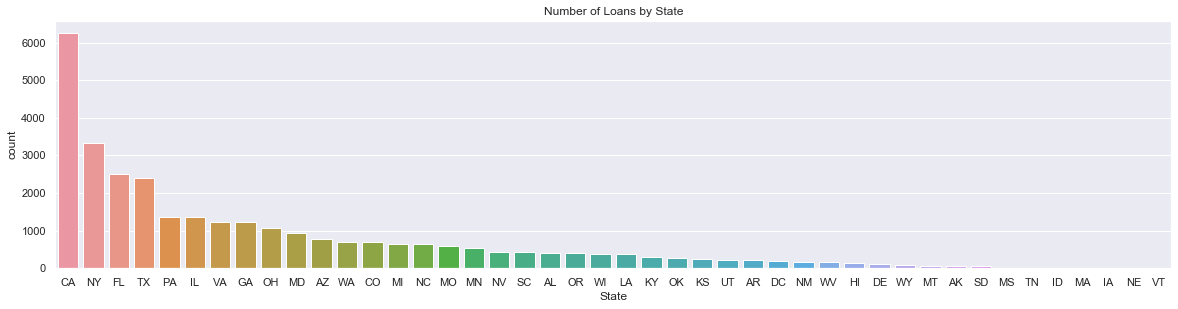

Pct  Cumulative Pct
CA  0.201319        0.201319
NY  0.107385        0.308705
FL  0.080740        0.389445
TX  0.077297        0.466742
PA  0.044023        0.510764
IL  0.043540        0.554304
VA  0.039807        0.594111
GA  0.039292        0.633403
OH  0.034690        0.668093
MD  0.030153        0.698246
AZ  0.025036        0.723282
WA  0.022848        0.746130
CO  0.022172        0.768302
MI  0.021142        0.789445
NC  0.020853        0.810298

In [155]:
# Quick look at distribution by state
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(2, 1, 1)
sns.countplot(data=training_pred, x="State", ax=ax, order=training_pred["State"].value_counts().index)
ax.set_title("Number of Loans by State")
plt.show();
# Percentage Accounted for
pct_loans_by_state = (training_pred["State"].value_counts().to_frame() / training_pred.shape[0])
pct_loans_by_state.columns = ["Pct"]
pct_loans_by_state["Cumulative Pct"] = pct_loans_by_state["Pct"].cumsum()
pct_loans_by_state.head(15)

What we have to include:
- `Loan Amount`
- `Interest Rate`
- `Homeownership`
- `Annual Income` & what to do with `Verification Status`
- `Debt-to-income Ratio`
- `GDP Quarterly Growth at Issuance`, `Statewide Unemployment at Issuance`

What we need to decide on:

- Loan Parameter: `Installment`, `Term`, `Issued Date`
- `Title`, `Description`, `Purpose`
- Employment Condition: `Employer Title`, `Employment Length`
- Macroeconomic Conditions: `Zipcode`, `State`, `Statewide Unemployment at Issuance`, `GDP Quarterly Growth at Issuance`
- Credit - late payments and other credit burdens: `Delinquencies in 2 years`, `Months Since Last Delinquency`, `Months Since Last Public Record`, `Inquiries in 6 months`, `Open Accounts`, `Derogatory Public Records`, `Public Bankcruptcy Records`
- Credit - utilization: `Revolving Balance Utilization`, `Revolving Balance`